# Predicting Burned Area of Bushfires by Using Meteorological Data


## Table of Contents

* [Introduction](#sec_1)
* [Data Exploration](#sec_2)
* [Model Development](#sec_3)
* [Model Comparison](#sec_4)
* [Variable Identification and Explanation](#sec_5)
* [Conclusion](#sec_6)
* [References](#sec_7)

## 1. Introduction <a class="anchor" id="sec_1"></a>

In this task, we are interested in exploring machine learning approaches
to predict the burned area of bushfires by using meteorological data that are
known to influence the wild fires. The dataset that we are going to use here were
originally collected from the northeast region of Portugal between January 2000
and December 2003. It contains geographical information, fire weather indices,
and the corresponding weather conditions. The aim is to build statistical models that can predict the burned area of the bushfires. 

The dataset contains 517 fire instances, each of which have 13 columns: the first
12 columns corresponding to the attributes (e.g., spatial coordinates, month,
day, four fire indices, and other meteorological data) and the last column containing the burned area, i.e., the variable that we will predict.

In [1]:
# turn off warnings
options(warn=-1)

# Libraries used
library(caret)
library(lars)
library(MASS)
library(randomForest)
library(corrplot)
library(ggcorrplot)
library(psych)
library(data.table)
library(e1071)
library(xgboost)
library(gbm)

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loaded lars 1.2

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

corrplot 0.84 loaded

Attaching package: 'psych'

The following object is masked from 'package:randomForest':

    outlier

The following object is masked from 'package:lars':

    error.bars

The following objects are masked from 'package:ggplot2':

    %+%, alpha

Loaded gbm 2.1.5


## 2. Data Exploration<a class="anchor" id="sec_2"></a>

In this section, we will explore the dataset and try to understand its compostion and distribution.

### 2.1 Descriptive Statistics

Lets start with seeing how the dataset looks, its structure and details about the data in each column.


In [2]:
# Reading the dataset which is saved in CSV file format 
full_data <- read.csv('forestfires.csv', header = TRUE, sep = ',')

#Printing the Number of Rows and Columns 
cat("The number of rows in the dataset =",dim(full_data)[1],"and the number of columns =",dim(full_data)[2])

#Viewing the First 5 Rows
head(full_data)

The number of rows in the dataset = 517 and the number of columns = 13

X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


Let us start with looking at the dataset's structure and details about the data in each column.

In [3]:
# summary of the dataset
str(full_data)

'data.frame':	517 obs. of  13 variables:
 $ X    : int  7 7 7 8 8 8 8 8 8 7 ...
 $ Y    : int  5 4 4 6 6 6 6 6 6 5 ...
 $ month: Factor w/ 12 levels "apr","aug","dec",..: 8 11 11 8 8 2 2 2 12 12 ...
 $ day  : Factor w/ 7 levels "fri","mon","sat",..: 1 6 3 1 4 4 2 2 6 3 ...
 $ FFMC : num  86.2 90.6 90.6 91.7 89.3 92.3 92.3 91.5 91 92.5 ...
 $ DMC  : num  26.2 35.4 43.7 33.3 51.3 ...
 $ DC   : num  94.3 669.1 686.9 77.5 102.2 ...
 $ ISI  : num  5.1 6.7 6.7 9 9.6 14.7 8.5 10.7 7 7.1 ...
 $ temp : num  8.2 18 14.6 8.3 11.4 22.2 24.1 8 13.1 22.8 ...
 $ RH   : int  51 33 33 97 99 29 27 86 63 40 ...
 $ wind : num  6.7 0.9 1.3 4 1.8 5.4 3.1 2.2 5.4 4 ...
 $ rain : num  0 0 0 0.2 0 0 0 0 0 0 ...
 $ area : num  0 0 0 0 0 0 0 0 0 0 ...


As can be seen, the data set includes two categorical variables, i.e., month and days, whereas all other columns contain numerical values distributed in different ranges. 

Let's look at the descriptive statistics of the dataframe to understand the specifics of the columns.

In [4]:
# descriptive statistics of the dataset
round(describe(full_data), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
X,1,517,4.669,2.314,4.00,4.672,2.965,1.0,9.00,8.00,0.036,-1.180,0.102
Y,2,517,4.300,1.230,4.00,4.308,1.483,2.0,9.00,7.00,0.415,1.378,0.054
month*,3,517,6.758,4.373,7.00,6.720,7.413,1.0,12.00,11.00,0.084,-1.719,0.192
day*,4,517,3.737,1.925,4.00,3.672,2.965,1.0,7.00,6.00,0.157,-1.109,0.085
FFMC,5,517,90.645,5.520,91.60,91.455,1.927,18.7,96.20,77.50,-6.537,66.139,0.243
DMC,6,517,110.872,64.046,108.30,106.522,51.743,1.1,291.30,290.20,0.544,0.179,2.817
DC,7,517,547.940,248.066,664.20,578.692,118.905,7.9,860.60,852.70,-1.094,-0.265,10.910
ISI,8,517,9.022,4.559,8.40,8.727,3.113,0.0,56.10,56.10,2.522,21.146,0.201
temp,9,517,18.889,5.807,19.30,19.091,5.337,2.2,33.30,31.10,-0.329,0.111,0.255
RH,10,517,44.288,16.317,42.00,42.706,14.826,15.0,100.00,85.00,0.858,0.409,0.718


The descriptive statistics give us a more information about variables:
- Overall, variables containing numerical values spanning across very different ranges. Hence it's better to consider normalising them before building models. 
- The target variable `area` spans across a very large range of values with a high skewness (skew = 12.772)
- Even though the `rain` variable has a much smaller value range, it's skewness is also very high (skew = 19.702)

    
### 2.2 Data Distribution of Variables with Graphical Statistics

Now, let us explore the distribution of the data with graphical statistics.


#### Distribution of Numerical Independent Variables

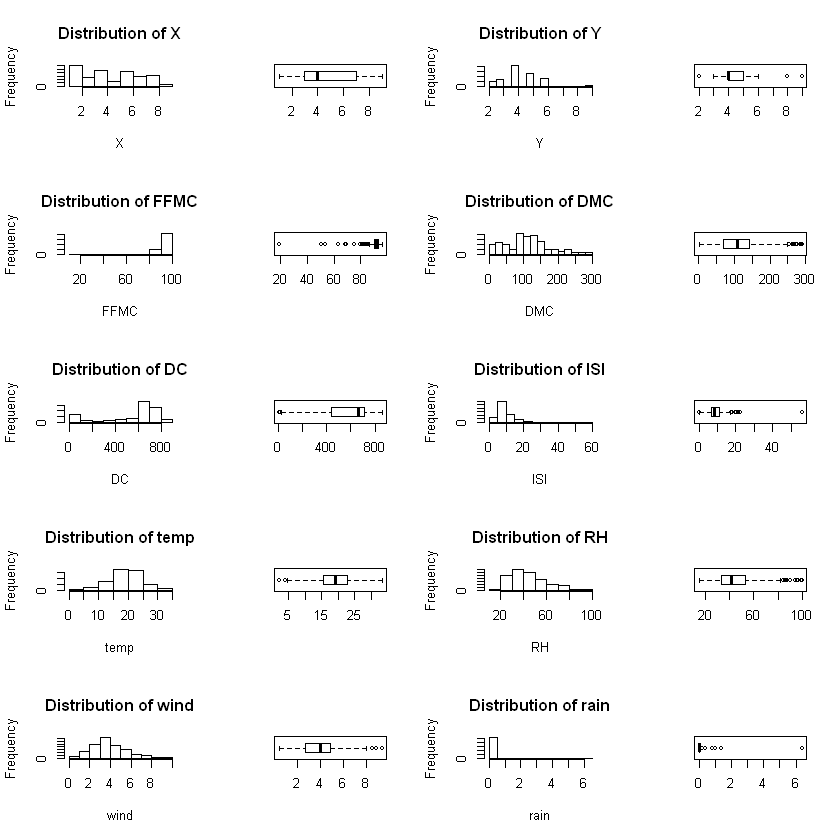

In [5]:
# Creating a subplot for each column
par(mfrow=c(5,4))

# Plotting the Histogram of the peroperty's distribution and a Boxplot to undetsand its variance if any

hist(full_data$X,main = 'Distribution of X',xlab="X")
boxplot(full_data$X, horizontal=TRUE)
hist(full_data$Y,main = 'Distribution of Y',xlab="Y")
boxplot(full_data$Y, horizontal=TRUE)
hist(full_data$FFMC,main = 'Distribution of FFMC',xlab="FFMC")
boxplot(full_data$FFMC, horizontal=TRUE)
hist(full_data$DMC,main = 'Distribution of DMC',xlab="DMC")
boxplot(full_data$DMC, horizontal=TRUE)
hist(full_data$DC,main = 'Distribution of DC',xlab="DC")
boxplot(full_data$DC, horizontal=TRUE)
hist(full_data$ISI,main='Distribution of ISI',xlab="ISI")
boxplot(full_data$ISI, horizontal=TRUE)
hist(full_data$temp,main='Distribution of temp',xlab="temp")
boxplot(full_data$temp, horizontal=TRUE)
hist(full_data$RH,main = 'Distribution of RH',xlab="RH")
boxplot(full_data$RH, horizontal=TRUE)
hist(full_data$wind,main='Distribution of wind',xlab="wind")
boxplot(full_data$wind, horizontal=TRUE)
hist(full_data$rain,main = 'Distribution of rain',xlab="rain")
boxplot(full_data$rain, horizontal=TRUE)

Several observations can be made from the above plots:
- Looking at the histograms, it can be seen that meterology variables such as `temp`, `wind`, `RH` tend to have normal distribution, which is great. 
- Based on the box plots, it appears that most numerical variables have outiliers. It could be good to considering removing those outliers from the data set. 

#### Definition of Useful User-defined Functions in this Notebook

In [6]:
get_original_numerical_variables <- function() {
  variables <- c('X','Y','FFMC','DMC','DC','ISI','temp','wind','RH','rain')
  return(variables)
}

In [7]:
get_original_variables <- function() {
  variables <- c('X','Y','day','month','FFMC','DMC','DC','ISI','temp','wind','RH','rain')
  return(variables)
}

In [8]:
get_original_target_variable <- function(){
    return('area')
}

In [9]:
get_original_data <- function(){
    data = full_data[c(get_original_variables(), get_original_target_variable())]
    return(data)
}

In [10]:
get_original_numerical_data <- function(){
    data = full_data[c(get_original_numerical_variables(), get_original_target_variable())]
    return(data)
}

In [11]:
get_subset <- function(df, columns){
    subset_df = df[columns]
    return(subset_df)
}

In [12]:
get_data_with_positive_area <- function(){
    # exclude rows where cannot be log transformed
    data = full_data[which(full_data$area > 0),]
    return(data)
}

#### Outlier Study

As we have seen that most numerical variables in the data set have outiliers. Here, we detect other outlier using cook distance.

In [13]:
outlier_model <- lm(area ~ ., data=get_original_data())
cooksd <- cooks.distance(outlier_model)

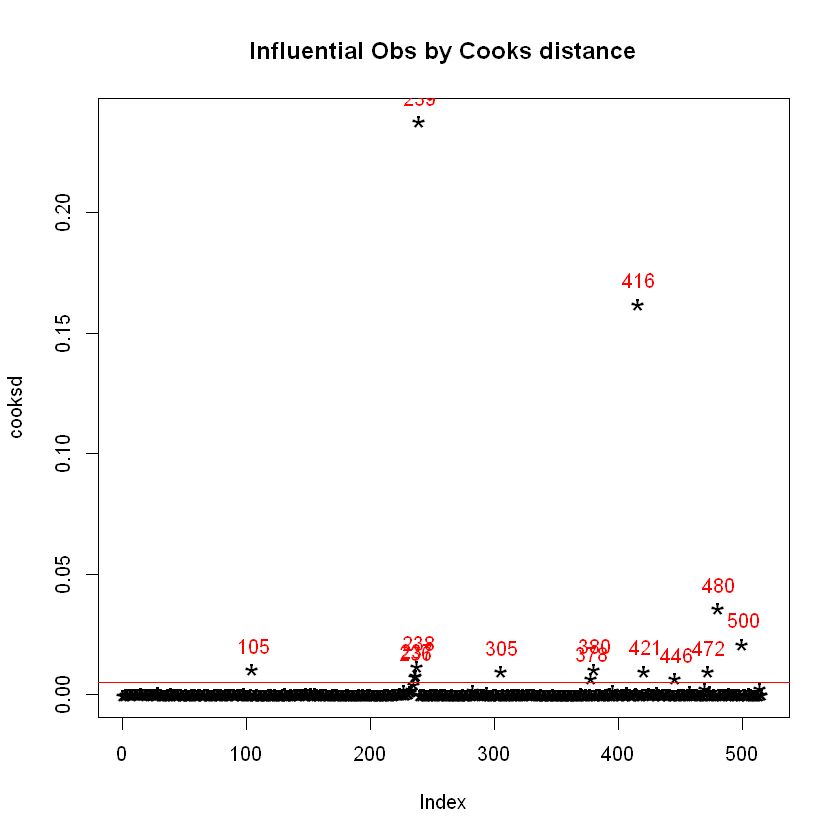

In [14]:
plot(cooksd, pch="*", cex=2, main="Influential Obs by Cooks distance")  # plot cook's distance
abline(h = 4*mean(cooksd, na.rm=T), col="red")  # add cutoff line
text(x=1:length(cooksd)+1, y=cooksd+0.01, labels=ifelse(cooksd>4*mean(cooksd, na.rm=T),names(cooksd),""), col="red")  # add labels

In [15]:
influential = which(cooksd>4*mean(cooksd, na.rm=T))

In [16]:
outlier_data = get_original_data()[influential, ]

In [17]:
outlier_data

,X,Y,day,month,FFMC,DMC,DC,ISI,temp,wind,RH,rain,area
105,2,4,sat,jan,82.1,3.7,9.3,2.9,5.3,3.1,78,0.0,0.00
236,8,6,sun,aug,91.4,142.4,601.4,10.6,19.6,5.8,41,0.0,196.48
237,2,2,sat,sep,92.5,121.1,674.4,8.6,18.2,1.8,46,0.0,200.94
238,1,2,tue,sep,91.0,129.5,692.6,7.0,18.8,2.2,40,0.0,212.88
239,6,5,sat,sep,92.5,121.1,674.4,8.6,25.1,4.0,27,0.0,1090.84
305,6,5,sat,may,85.1,28.0,113.8,3.5,11.3,4.9,94,0.0,0.00
378,2,2,sat,aug,93.7,231.1,715.1,8.4,21.9,2.2,42,0.0,174.63
380,4,5,sun,jan,18.7,1.1,171.4,0.0,5.2,0.9,100,0.0,0.00
416,8,6,thu,aug,94.8,222.4,698.6,13.9,27.5,4.9,27,0.0,746.28
421,8,8,wed,aug,91.7,191.4,635.9,7.8,26.2,4.5,36,0.0,185.76


There are not many outliers detected by cook distance, hence removing them or not may not impact the performance of the models. However, that can be justified by actually building the model later on.

#### Statistics of Categorical Independent (Temporal) Variables

The `day` variable apparently should have no impact on the burned area. However, it is possible that the `month` may have a big impact depending on which season the month belongs to, hence affecting the temperature and burned area.
Let us study this hypothesis via some graphical statistics.

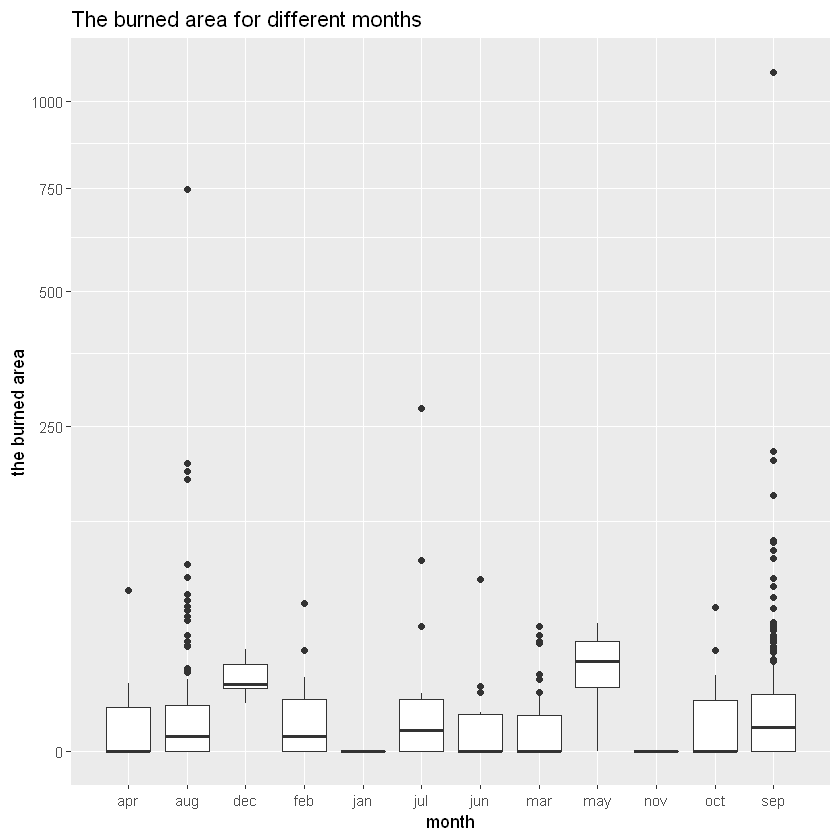

In [18]:
ggplot(full_data, aes(full_data$month, full_data$area)) + geom_boxplot() + coord_trans(y = "sqrt") + 
labs(x = "month", y = "the burned area", title ="The burned area for different months")

As can be seen, there are much more large bushfires in the months of Aug, Sep, Jun, Jul. Therefore, this temporal variable could be a contributing factor to the model.

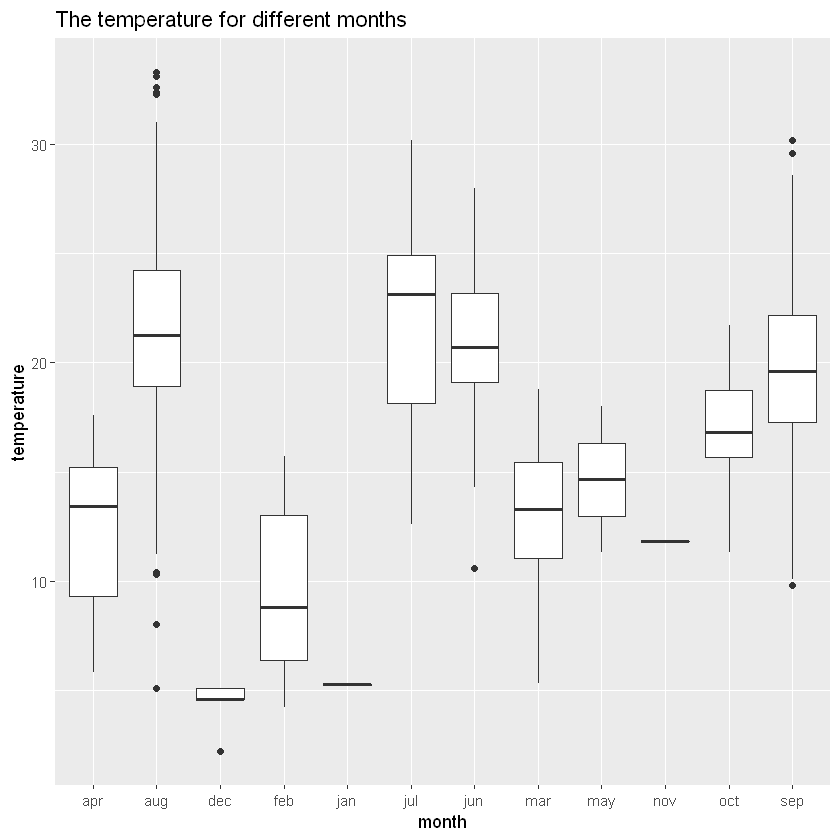

In [19]:
ggplot(full_data, aes(full_data$month, full_data$temp)) + geom_boxplot() + 
labs(x = "month", y = "temperature", title ="The temperature for different months")

Interestingly, the above plot also confirms that the `month` variable also impacts the `temp` variable with the same pattern: Aug, Sep, Jun, Jul are the months with the high temperatures (and large burned areas). Hence, `month` and `temp` variables could have collinearity relationship when predicting the burned `area`.


#### Distribution of Target Variable

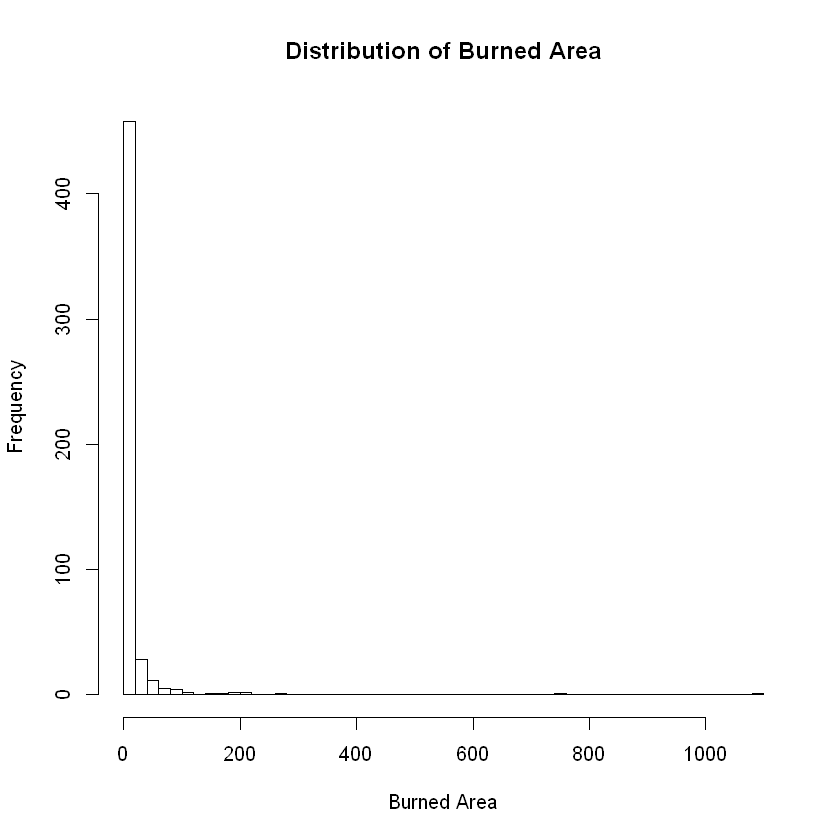

In [20]:
# Plotting the historgram for the target variable
hist(full_data$area, 50, main='Distribution of Burned Area', xlab = 'Burned Area')

Simiar to descriptive statistics, the graphical ouput confirms that the distribution of the `area` is skewed with a very high distribution of burned area values around 0-50 range.

#### Transformation of Target Variable

In [21]:
full_data$logarea <- ifelse(full_data$area > 0, log(full_data$area), NA)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


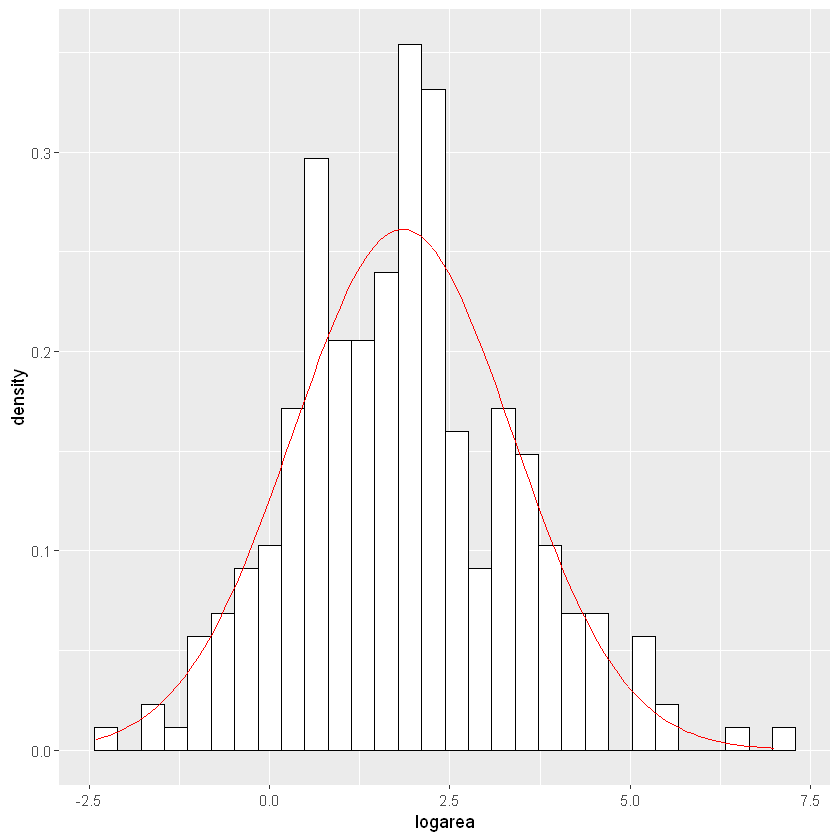

In [22]:
ggplot(full_data, aes(x = logarea)) + 
  geom_histogram(aes(y = ..density..), colour = "black", fill = "White") +
  stat_function(fun = dnorm, args = list(mean = mean(full_data$logarea,na.rm=TRUE)
                                         , sd = sd(full_data$logarea,na.rm=TRUE)),col = 'red')

The above plot shows that the transformed `logarea` is approximately normally distributed. It is suited to be a new target variable when building the models. 

### 2.3 Correlation between Independent Variables and Target Variable

Another method to check the importance/impact of a feature on the target is by checking their correlation.

Firstly, let have a lot at the pairwise scatter plots. 

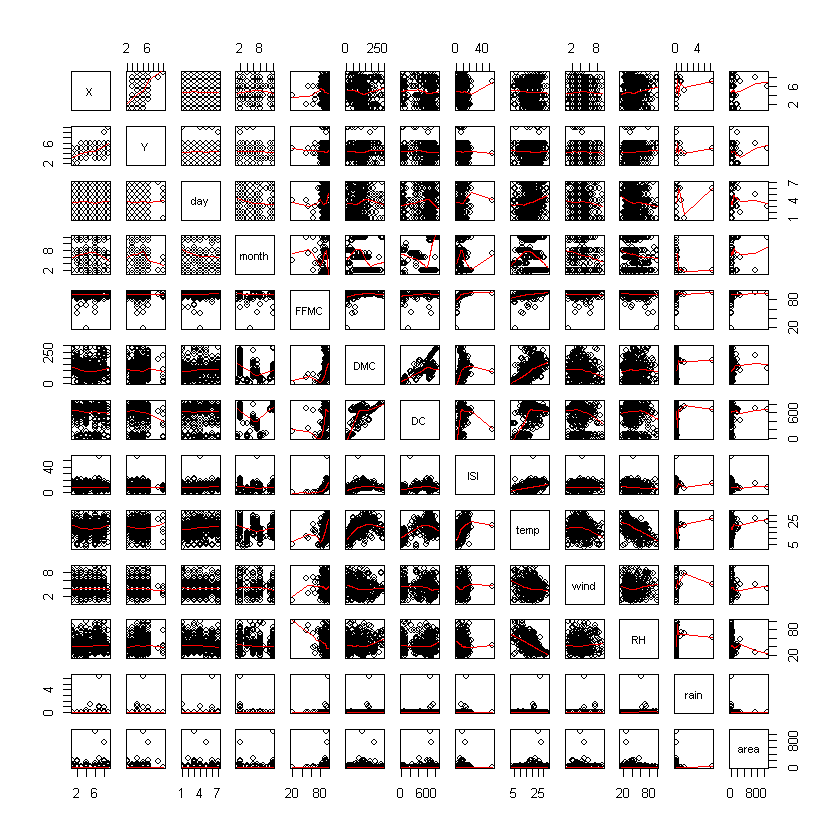

In [23]:
pairs(get_original_data(),panel = panel.smooth)

This plot clearly shows some patterns between variables:
- `month` and `temp` variables are clearly correlated
- `temp` and `RH` variables seems correlated
- `temp` variable clearly impacts other bushfire index including `FFMC`, `DMC`, `DC`, `ISI`
- Meteorological conditions (e.g., `temperature` and `wind`) have a strong impact on the burned `area`

Secondly, we can further study the correlation scores between variables to confirm the above observations.

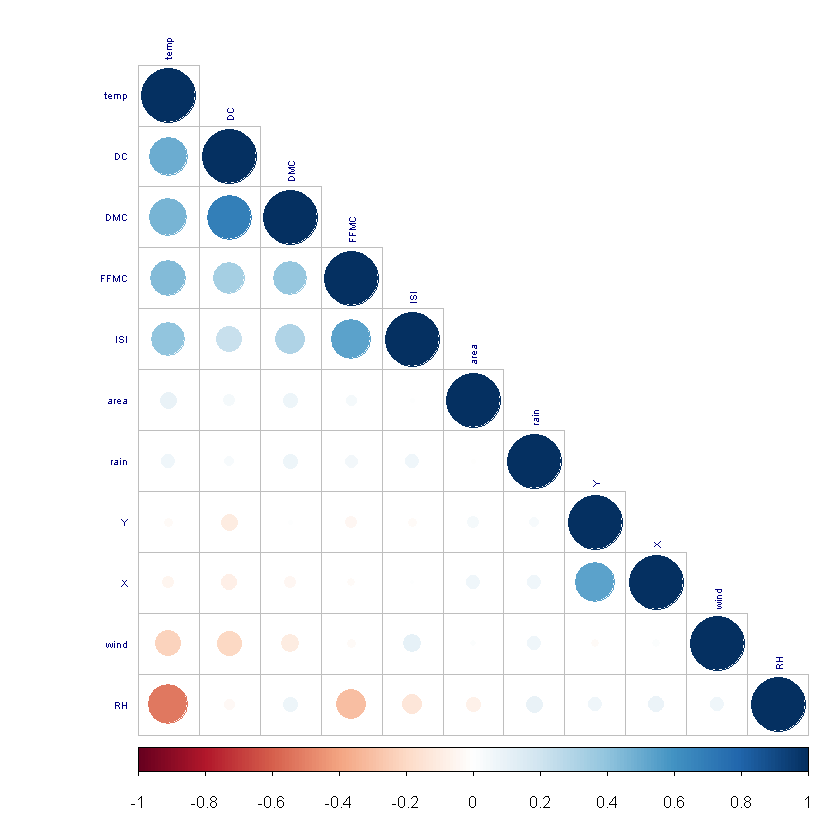

In [24]:
corrplot(cor(get_original_numerical_data()), method = "circle",type='lower',order = "FPC", addrect = 10,tl.cex = 0.5,diag = TRUE,tl.col = "navyblue")

This correlation plot confirms the following observations:
- `temp` variable clearly impacts other bushfire indexes including `FFMC`, `DMC`, `DC`, `ISI`
- Meteorological conditions (especially the `temperature`) have a considerable impact on the target burned `area`
- Features are correlated to each other, particularly `temp` and `RH` variables have negative correlation, which can raise the issue of `multi-collinearity` when building prediction model.

#### Conclusions after EDA Study

The following conclusions can be made after the above EDA study:
- Because `temp` variable clearly impacts other bushfire indexes including `FFMC`, `DMC`, `DC`, `ISI`, we can exclude those bushfire indexes when building prediction model for burned `area`.
- Meteorological conditions (especially the `temp` variable) have a considerable impact on the target burned `area`
- Temporal variables such as `month` have a significant impact on the temperature `temp`, which in its turn affects the target burned `area`. Therefore, it is also fine to exclude temporal variables such as `month` and `day` 
- Overall, the remaining features to be considered in building prediction model for burned `area`:
    - X, Y
    - temp, wind, RH, rain

In [25]:
eda_selected_variables = c('X', 'Y', 'temp', 'wind', 'RH', 'rain')

## 3. Model Development<a class="anchor" id="sec_3"></a>

### 3.1 Data Preparation

Here, we split the original data set into training set and test set for evaluation purpose.

We only consider numerical features selected from the above EDA study, whereas categorical (temporal) features and other bushfire indexes are excluded because they either have no impact on the target variable or have colinearity relationship with temperature feature.

In [26]:
# Splitting the final subset data in the ratio 85 : 15 for training:testing
set.seed(2020)

temp_data <- get_subset(full_data, c(eda_selected_variables, get_original_target_variable()))

split <- sample(nrow(temp_data), 0.85*nrow(temp_data), replace = FALSE)

train <- temp_data[split,] # Assigning training data
test <- temp_data[-split, eda_selected_variables] # Assigning test data

truth_value <- temp_data[-split, get_original_target_variable()] # The true values of the target from the test data 

Size of train data set:

In [27]:
dim(train) 

[1] 439   7

Size of test data set:

In [28]:
dim(test)
length(truth_value)

[1] 78  6

[1] 78

### 3.2 Boosted Tree

Perform boosting on the training set with 1000 trees for a range of values of the shrinkage parameter $\lambda$.
Produce twos plots:
* one with different shrinkage values on the x-axis and the corresponding training set RMSE on the y-axis.
* one with different shrinkage values on the x-axis and the corresponding testing set RMSE on the y-axis.

In [29]:
set.seed(1)

In [30]:
pows = seq(-10, -0.2, by = 0.1)
lambdas = 10^pows
length.lambdas = length(lambdas)
train.errors = rep(NA, length.lambdas)
test.errors = rep(NA, length.lambdas)

In [31]:
for (i in 1:length.lambdas) {
    boost.model = gbm(area ~ ., data = train, distribution = "gaussian", n.trees = 1000, shrinkage = lambdas[i])
    train.pred = predict(boost.model, train, n.trees = 1000)
    test.pred = predict(boost.model, test, n.trees = 1000)
    train.errors[i] = sqrt(mean((train$area - train.pred)^2))
    test.errors[i] = sqrt(mean((truth_value - test.pred)^2))
}

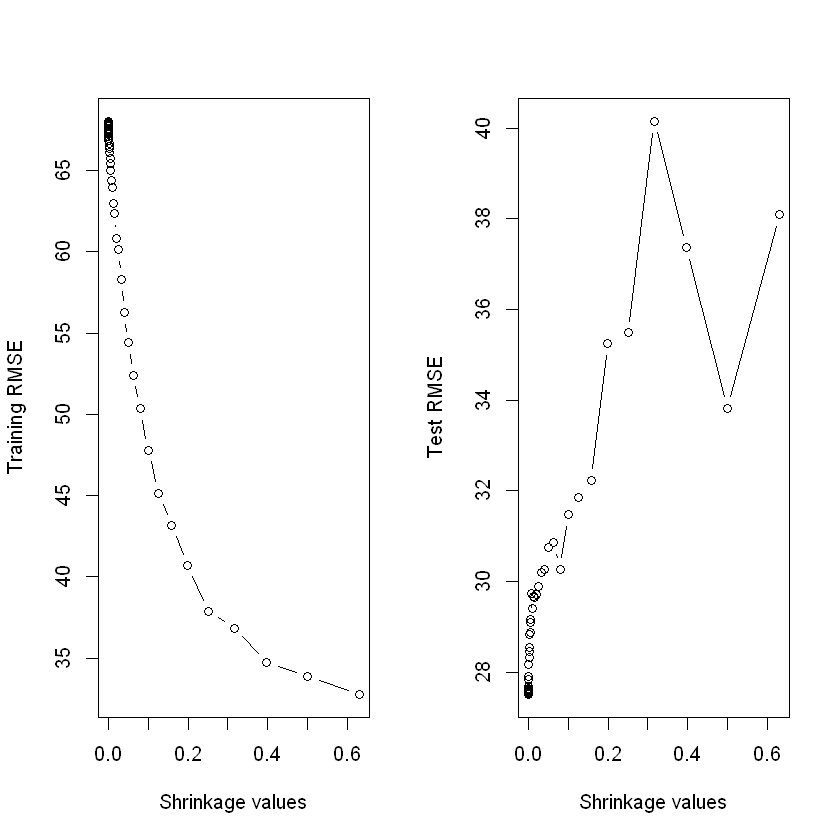

In [32]:
par(mfcol=c(1,2))
plot(lambdas, train.errors, type = "b", xlab = "Shrinkage values", ylab = "Training RMSE")
plot(lambdas, test.errors, type = "b", xlab = "Shrinkage values", ylab = "Test RMSE")

Optimal shinkage value regarding test RMSE: 

In [33]:
min(test.errors)

[1] 27.50384

In [34]:
lambdas[which.min(test.errors)]

[1] 0.0002511886

Build the boosted tree model using the above selected parameter:

In [35]:
best.boost.model <- gbm(area ~ ., data = train, distribution = "gaussian", n.trees = 1000, shrinkage = lambdas[which.min(test.errors)])

Importance of Variables:

,var,rel.inf
temp,temp,88.2251702
RH,RH,6.8948407
X,X,4.1973237
Y,Y,0.5723017
wind,wind,0.1103637
rain,rain,0.0000000


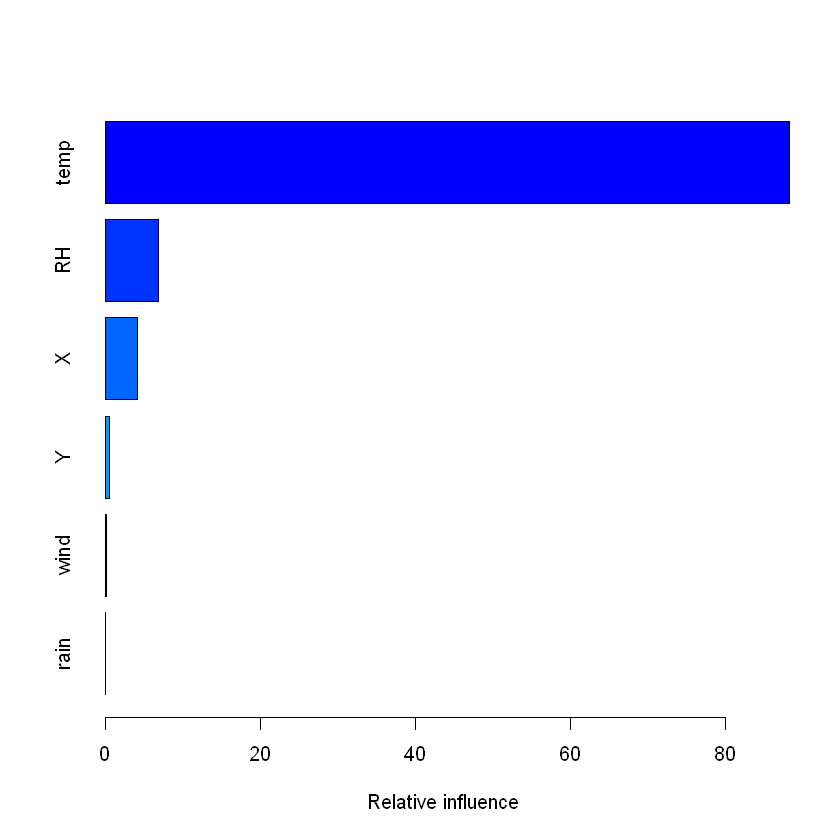

In [36]:
summary(best.boost.model)

### 3.3 Baseline Linear Regression

In [37]:
# Training the Model using the train data 
linear_model<- lm(area~., train)

In [38]:
# Summary of the Linear Model
summary(linear_model)


Call:
lm(formula = area ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
 -41.26  -16.23   -9.24   -0.54 1064.25 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) -23.1466    26.4822  -0.874   0.3826  
X             2.1701     1.6583   1.309   0.1914  
Y             0.9844     3.1159   0.316   0.7522  
temp          1.1795     0.7047   1.674   0.0949 .
wind          1.4127     1.8737   0.754   0.4513  
RH           -0.1283     0.2410  -0.532   0.5947  
rain         -4.3414    10.3543  -0.419   0.6752  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 67.89 on 432 degrees of freedom
Multiple R-squared:  0.01993,	Adjusted R-squared:  0.006313 
F-statistic: 1.464 on 6 and 432 DF,  p-value: 0.189


The p value of `temp` variable is 0.09, which confirms that the `temp` feature has the highest impact on the target `burned`area.

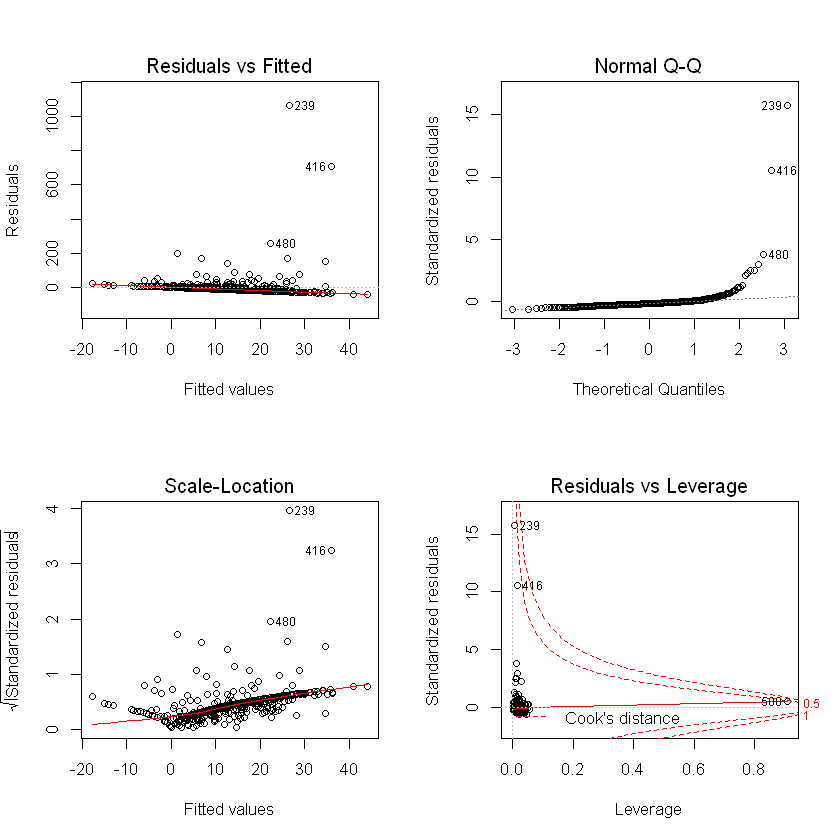

In [39]:
# Plot The Diagnostic Plots of the model.
par(mfrow = c(2,2))
plot(linear_model)

The above diagnostic plots show that the linear regression model does not fit well the training data.

## 3.4 Random Forest

In this model we will apply the Random Forest regression method. The Random Forest method is a prediction algorithm that uses a very large number of decision tress built from various different samples of the input dataset. 

In [40]:
# Fitting the Random Forest Model specifying the Target and the right Subset of features.
# Poviding the number of tree - 1000
# Providing number of variables to select per split - 6

rdf_model <- randomForest(area ~ ., data = train, ntree = 1000, mtry = 6, importance = TRUE)

In [41]:
# Displaying the features based on calculated importance of the feature.
importance(rdf_model)

,%IncMSE,IncNodePurity
X,-4.6922903,97420.6230
Y,-5.3852533,68457.0456
temp,0.3113507,1358594.7128
wind,5.0721985,165432.1908
RH,2.3235673,101407.5186
rain,1.5604097,155.4412


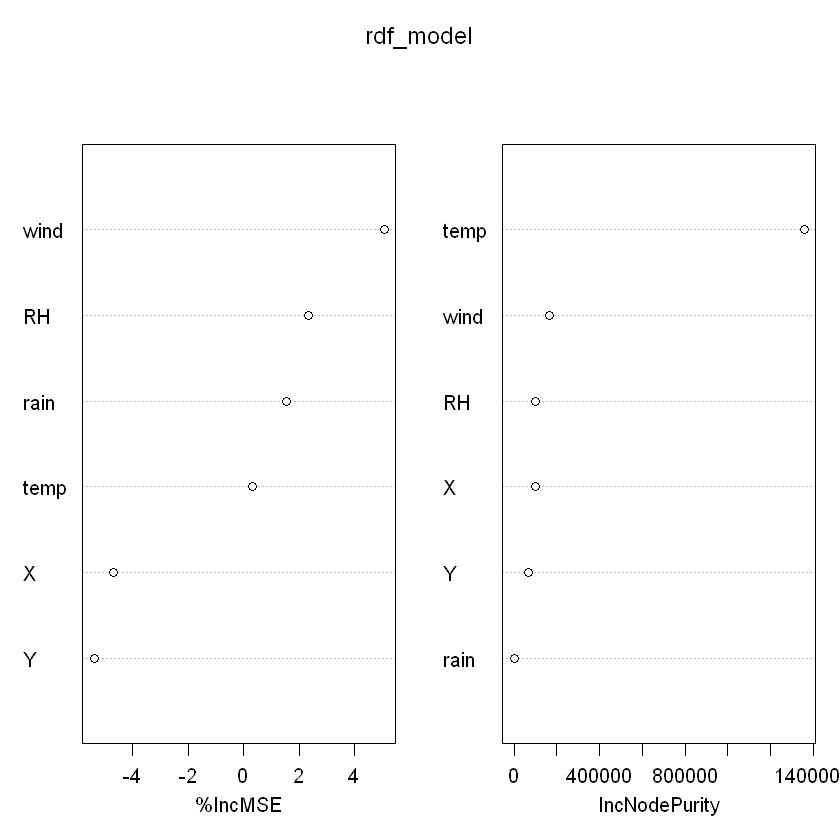

In [42]:
varImpPlot(rdf_model)

This result again confirms that the `temp` feature is the most dominant feature in the model.

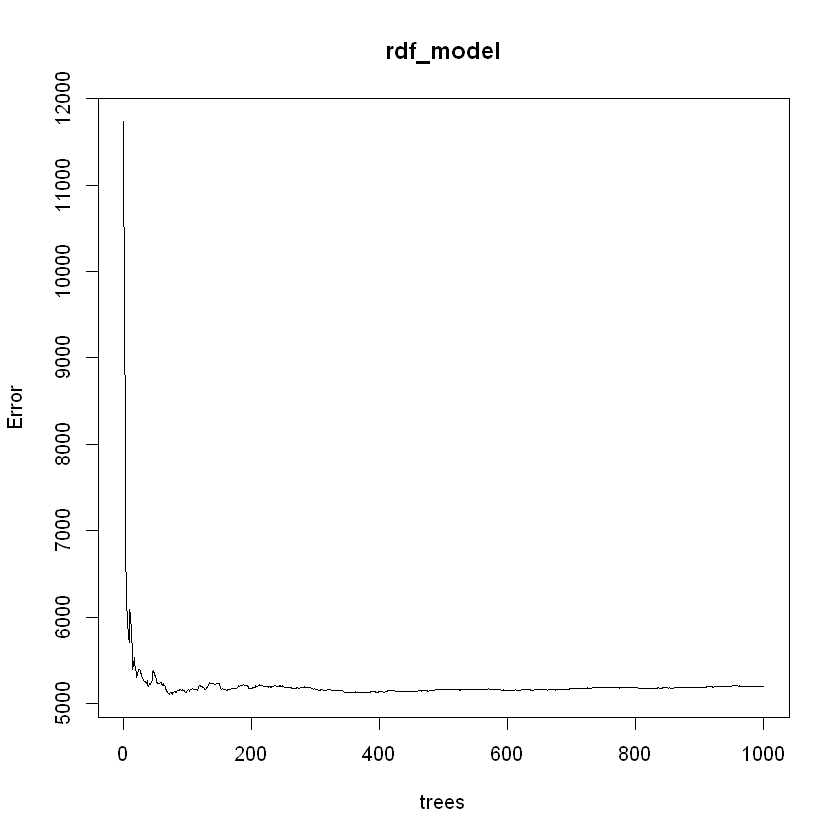

In [43]:
plot(rdf_model)

- The error vs tress graph above is graphical representation of the accuracy of the Random forest model as it varies with the number of trees selected while training the model.
- From the above plot we see that it is not required upto 1000 trees to arrive at a Model with similar accuracy.
- This plot shows we could have trained the model in a range of 50 to 400 trees and arrived at a similar accuracy for the model.

### 3.5 Support Vector Machine

In [44]:
svm_model = svm(area ~ ., data = train, kernel = "linear", cost = 10, scale = FALSE)

In [45]:
print(svm_model)


Call:
svm(formula = area ~ ., data = train, kernel = "linear", cost = 10, 
    scale = FALSE)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  linear 
       cost:  10 
      gamma:  0.1666667 
    epsilon:  0.1 


Number of Support Vectors:  430



As can be seen, there are 430 support vectors from the training data set.

## 4. Model Comparsion<a class="anchor" id="sec_4"></a>

As we conclude our model development, we shall now look at a method to compare models and how we can decide which prediction model would be best suitable for our purpose.
    - In particular, the partitioned (train & test) data to predict values on the Test data and compare its difference from out truth values
    - This method allows us to compute the Root Mean Squared Error (RMSE) of each model.
    - We will also display a scatter plot of the Truth Values Vs. Predicted values for each model

### 4.1 Performance of Boosted Tree

In [46]:
# Predicting the target values
prediction_boost<-predict(best.boost.model, test, n.trees = 1000)

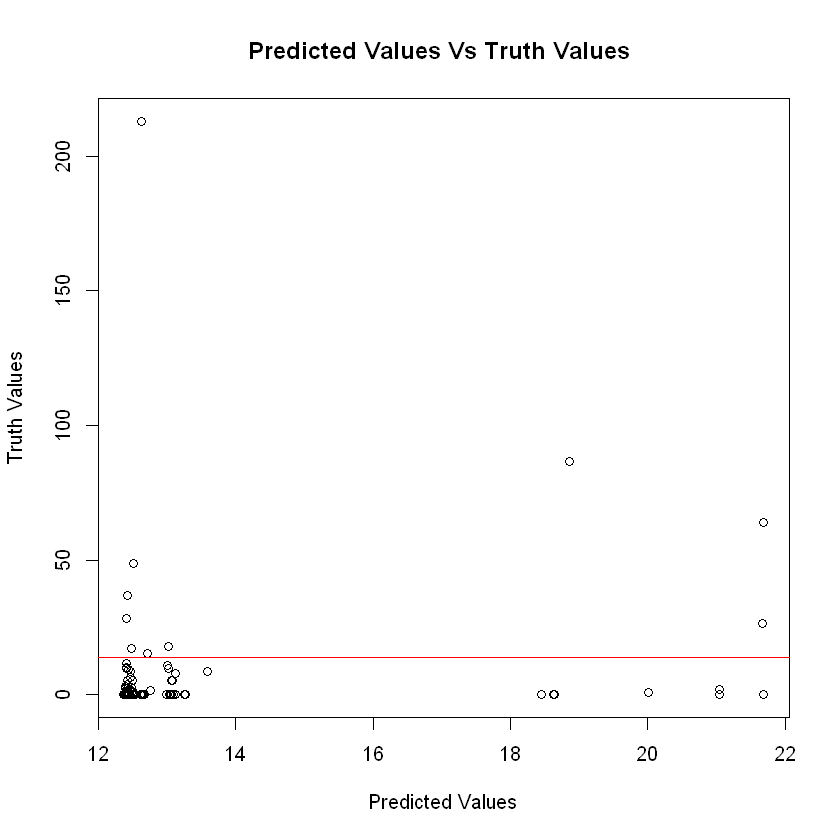

In [47]:
# Plotting the Predicted Values Vs Truth Values
plot((prediction_boost),truth_value,main = 'Predicted Values Vs Truth Values ',xlab='Predicted Values',ylab='Truth Values')
abline(lm(prediction_boost~truth_value), col="red")

In [48]:
# Printing the RMSE
mse_boost <- mean((truth_value - prediction_boost)^2)
cat('The RMSE for the Boosted Tree Model is', sqrt(mse_boost))

The RMSE for the Boosted Tree Model is 27.51085

### 4.2 Performance of Linear Regression

In [49]:
# Predicting the target values for the Linear Model
prediction_lm<-predict(linear_model, test)

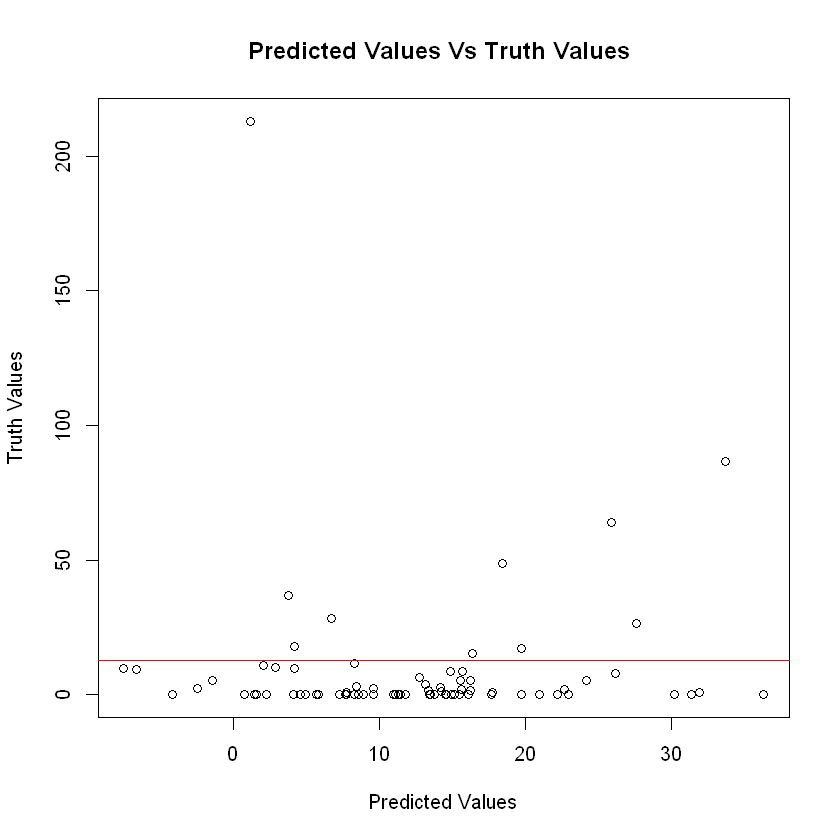

In [50]:
# Plotting the Predicted Values Vs Truth Values for the Linear Model
plot((prediction_lm),truth_value,main = 'Predicted Values Vs Truth Values ',xlab='Predicted Values',ylab='Truth Values')
abline(lm(prediction_lm~truth_value), col="red")

In [51]:
# Printing the RMSE for the Linear model based on the prediction done
mse_lm <- mean((truth_value - prediction_lm)^2)
cat('The RMSE for the Linear Model is ', sqrt(mse_lm))

The RMSE for the Linear Model is  28.99109

### 4.3 Performance of Random Forest

In [52]:
# Predicting the target values for the Random Forest Model
prediction_rdf<-predict(rdf_model, test)

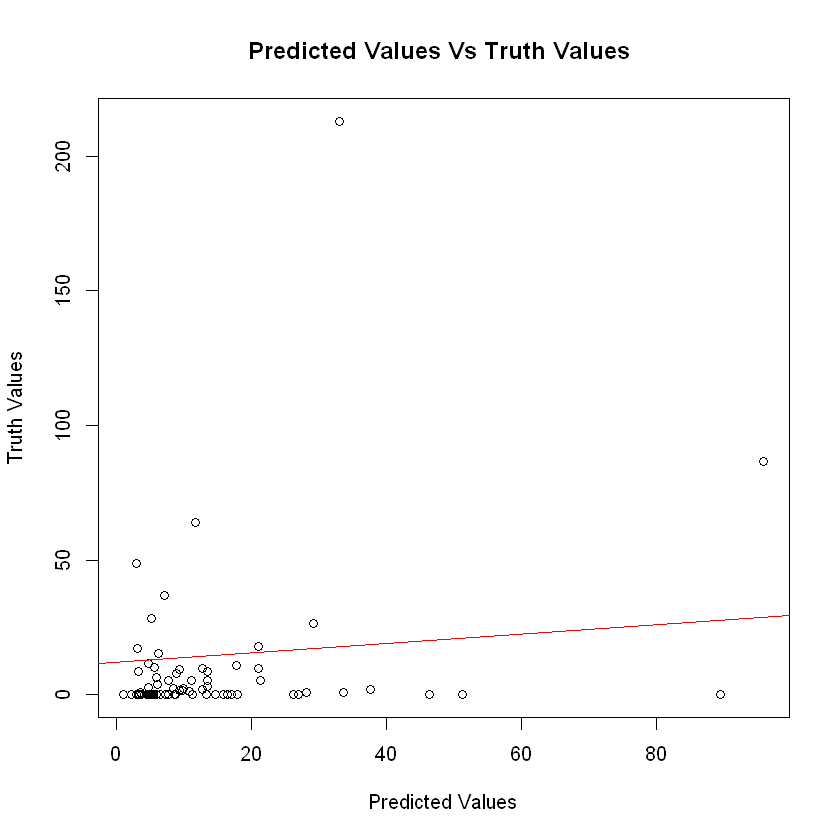

In [53]:
# Plotting the Predicted Values Vs Truth Values

plot((prediction_rdf),truth_value, main = 'Predicted Values Vs Truth Values ',xlab='Predicted Values',ylab='Truth Values')
abline(lm(prediction_rdf~truth_value), col="red")

In [54]:
# Printing the RMSE
mse_rdf <- mean((truth_value - prediction_rdf)^2)
cat('The RMSE for the Random Forest Model is', sqrt(mse_rdf))

The RMSE for the Random Forest Model is 27.78662

### 4.4 Performance of SVM

In [55]:
# Predicting the target values for the Random Forest Model
prediction_svm<-predict(svm_model, test)

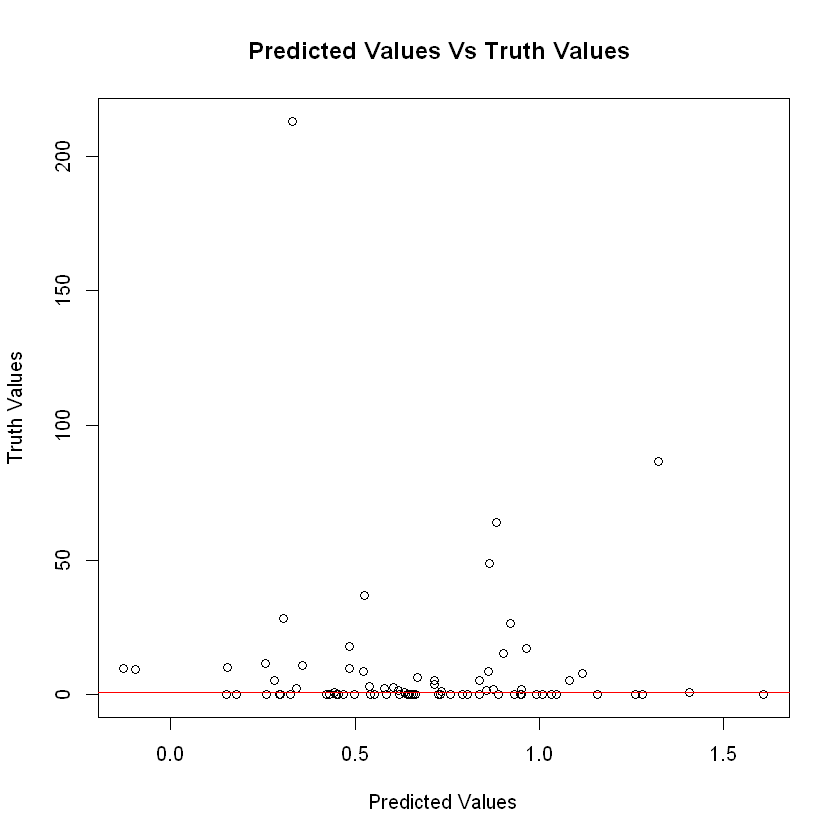

In [56]:
# Plotting the Predicted Values Vs Truth Values for the Linear Model

plot((prediction_svm),truth_value,main = 'Predicted Values Vs Truth Values ',xlab='Predicted Values',ylab='Truth Values')
abline(lm(prediction_svm~truth_value), col="red")

In [57]:
mse_svm <- mean((truth_value - prediction_svm)^2)
cat('The RMSE for the SVM Model is',sqrt(mse_svm))

The RMSE for the SVM Model is 28.45853

### 4.5 Conclusion of Model Comparison

The RMSE of a model is a very convenient method to judge the accuracy of a model and can be easily computed for any type of regression model. 

Based on the above calculated RSMEs for different models, we can conclude this model comparison with the `Boosted Tree` coming out as the `Clear winner` with its own shrinkage parameter optimised in the model development section.


## 5. Variable Identification and Explanation <a class="anchor" id="sec_5"></a>

As a result of the EDA study (section 2), we only consider numerical features including geographical locations and meterology conditions, whereas categorical (temporal) features and other bushfire indexes are excluded because they either have no impact on the target variable or have colinearity relationship with temperature feature.
    - Geographical locations: X, Y
    - Metorology conditions: temp, wind, RH, rain


In addition, the selected best prediction model (Boosted Tree) also provided us guidance of variable importance.

,var,rel.inf
temp,temp,88.2251702
RH,RH,6.8948407
X,X,4.1973237
Y,Y,0.5723017
wind,wind,0.1103637
rain,rain,0.0000000


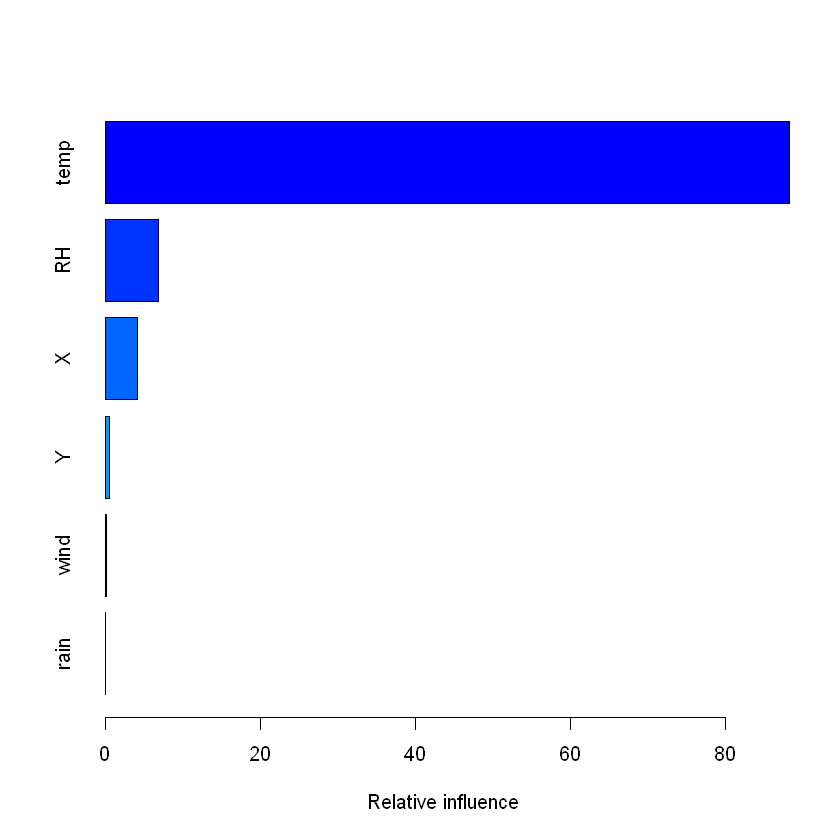

In [58]:
summary(best.boost.model)

From the above variable importance result, we can select the most important features for predicting the burned area:
    - Geographical locations: X, Y
    - Meteorological conditions: temp, RH, wind

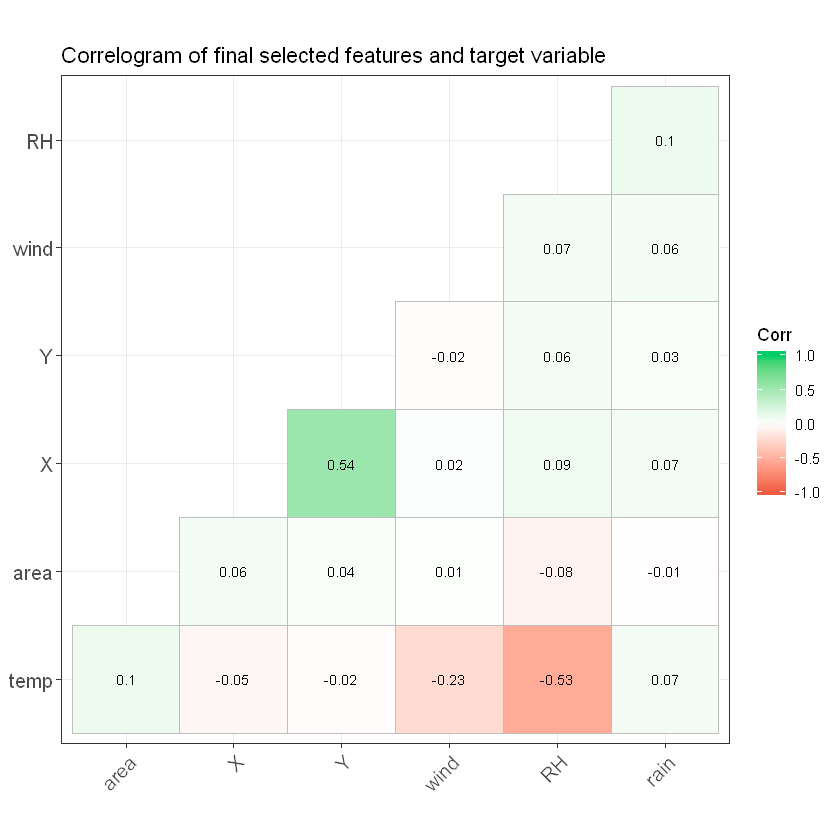

In [59]:
corr_matrix <- round(cor(get_subset(full_data,c('X','Y','temp','RH','wind', 'rain', 'area'))), 2)
ggcorrplot(corr_matrix, hc.order = TRUE, 
           type = "lower", 
           lab = TRUE, 
           lab_size = 3, 
           method="square", 
           colors = c("tomato2", "white", "springgreen3"), 
           title="Correlogram of final selected features and target variable", 
           ggtheme=theme_bw)

The correlation scores of final selected variables with regard to the target variable are not very strong, indicating this is really a hard prediction problem. However, the variable selection done by EDA and model development is also very reasonable given the data we have at hand:
    - The location of the bushfire impacts burned area due to specific vegetation and elevation properties associated with that location.
    - The meteorological conditions, especially the temperature, are the key factors affecting the ignition and spreading of the bushfire as shown in the EDA study.

## 6. Conclusion <a class="anchor" id="sec_6"></a>

After EDA study, we were able to segregate certain variable as insignificant to the target, cerain variables were discarded for Multicollinearity. 

To predict the burned area, four Models were developed and compared for their accuracy in prediction. The Boosted Tree Model outperformed other three models and confirmed the most important features including geolocations of the bushfires and meteoroglogy conditions.

## 7. References <a class="anchor" id="sec_7"></a>

* A Data Mining Approach to Predict Forest Fires using Meteorological data - http://www3.dsi.uminho.pt/pcortez/fires.pdf 

* Existing analysis - http://www.columbia.edu/~yh2693/ForestFire.html

* Sample analysis - https://www.kaggle.com/elikplim/predict-the-burned-area-of-forest-fires

* Corrplot - https://cran.r-project.org/web/packages/corrplot/vignettes/corrplot-intro.html

* Corrplot- https://rstudio-pubs-static.s3.amazonaws.com/240657_5157ff98e8204c358b2118fa69162e18.html
